In [1]:
import torch
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset

In [2]:
data = pd.read_csv("order-data.csv")
data = data.iloc[:,1:105]
data.head()

,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,101,102,103,104
0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,7.0,0.0,0.0,...,57.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,85.0,0.0,0.0,0.0,58.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,523.0,0.0,0.0,0.0,12.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,253.0,0.0,0.0,0.0,132.0,0.0,0.0,...,227.0,0.0,0.0,0.0,0.0,173.0,0.0,0.0,0.0,785.0
4,0.0,0.0,0.0,455.0,0.0,0.0,0.0,302.0,0.0,0.0,...,434.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,0.0,1028.0


# Normalize the data

In [3]:
data_temp_array = data.to_numpy()


In [4]:
# experimental cell

mydf = pd.DataFrame({'A': [1, 2, 5],
                   'B': [88, 300, 200]})

# Find and store min and max vectors
min_values = mydf.min()
max_values = mydf.max()


print(min_values)
print(max_values)

normalized_df = (mydf - min_values) / (mydf.max() - min_values)
print(normalized_df)

denormalized_df= normalized_df * (max_values - min_values) + min_values
print(denormalized_df)


A     1
B    88
dtype: int64
A      5
B    300
dtype: int64
      A         B
0  0.00  0.000000
1  0.25  1.000000
2  1.00  0.528302
     A      B
0  1.0   88.0
1  2.0  300.0
2  5.0  200.0


In [12]:
# Find and store min and max vectors
min_values = data.min()
max_values = data.max()

#print(min_values)
#print(max_values)

data_normalized = (data - min_values) / (data.max() - min_values)
data_normalized = data_normalized.fillna(0)
print(data_normalized)

# selecting the training data. Use 100 weeks and leave 4 weeks out.
data_train = data_normalized.iloc[:,:-4]

inputs = torch.Tensor(data_train.values).unsqueeze(1) # torch.Size([21541, 1, 100])

targets = data_train.iloc[:, 4:]
#print(targets.shape)
temp_data = data_train.iloc[:, 96:]
targets = np.append(targets, temp_data, 1)
#print(targets.shape)

targets = torch.Tensor(targets)

         1    2    3         4    5    6    7         8    9   10  ...  \
0      0.0  0.0  0.0  0.000209  0.0  0.0  0.0  0.000163  0.0  0.0  ...   
1      0.0  0.0  0.0  0.001112  0.0  0.0  0.0  0.001347  0.0  0.0  ...   
2      0.0  0.0  0.0  0.006839  0.0  0.0  0.0  0.000279  0.0  0.0  ...   
3      0.0  0.0  0.0  0.003309  0.0  0.0  0.0  0.003066  0.0  0.0  ...   
4      0.0  0.0  0.0  0.005950  0.0  0.0  0.0  0.007015  0.0  0.0  ...   
...    ...  ...  ...       ...  ...  ...  ...       ...  ...  ...  ...   
21536  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
21537  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
21538  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
21539  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
21540  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   

             95   96   97   98   99       100  101  102  103       104  
0      0.001226  0.0  0.0  0.0  0.0  0

# Defining our model

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1):
        super(RNN, self).__init__()
        
        # hidden dimension size
        self.hidden_size = hidden_size
        
        # Add an LSTM/GRU layer:
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        
        # Add a fully-connected layer:
        self.output = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, hidden

# Instantiate the model, define loss and optimization functions

In [14]:
model = RNN(data_train.shape[1], 10, 100)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000

model

RNN(
  (rnn): GRU(100, 10, batch_first=True)
  (output): Linear(in_features=10, out_features=100, bias=True)
)

In [15]:
import time

start_time = time.time()
losses = []

for i in range(1, epochs+1):
    
    hidden = None
    pred, hidden = model(inputs, hidden)
    
    loss = criterion(pred, targets)
    # reset the parameters and hidden states
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if i%100 == 0:
        # print training result
        print(f'Epoch: {i} Loss: {loss.item():10.8f}')
        

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch: 100 Loss: 0.00239883
Epoch: 200 Loss: 0.00009639
Epoch: 300 Loss: 0.00007554
Epoch: 400 Loss: 0.00007201
Epoch: 500 Loss: 0.00006866
Epoch: 600 Loss: 0.00006541
Epoch: 700 Loss: 0.00006232
Epoch: 800 Loss: 0.00005944
Epoch: 900 Loss: 0.00005675
Epoch: 1000 Loss: 0.00005422

Duration: 67 seconds


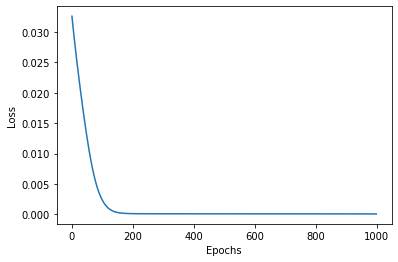

In [16]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [29]:
npdata = (pred.detach().numpy())
predicted_values = pd.DataFrame(data=npdata)

print(predicted_values.iloc[:, 96:])

#denormalized_df= predicted_values * (max_values - min_values) + min_values
#print(denormalized_df)

# inverse transform and print the first 5 rows
#npdata.iloc[:, 100:] = np.arange()

#inversed = scaler.inverse_transform(npdata)
#inversed

             96        97        98        99
0      0.000595 -0.000675  0.000398  0.001735
1      0.000528 -0.000724 -0.000002  0.001662
2      0.000778 -0.000820  0.000164  0.001450
3     -0.000908  0.000602 -0.000182  0.002860
4     -0.000215  0.000848 -0.001324  0.002529
...         ...       ...       ...       ...
21536  0.000621 -0.000716  0.000419  0.001657
21537  0.000620 -0.000715  0.000419  0.001660
21538  0.000621 -0.000716  0.000419  0.001657
21539  0.000621 -0.000716  0.000419  0.001657
21540  0.000621 -0.000716  0.000419  0.001657

[21541 rows x 4 columns]


In [ ]:
npdata = (pred.detach().numpy())

unscaled = scaler.inverse_transform(npdata)
unscaled

data_normalized = pd.DataFrame(data=unscaled)
unscaled = scaler.inverse_transform(data_normalized)

unscaled = pd.DataFrame(data=unscaled)
unscaled

#scaler2 = MinMaxScaler()
#unscaled = scaler2.inverse_transform(predicted_values)

#unscaled


#data_normalized = pd.DataFrame(data=scaled_data)
#unscaled = scaler.inverse_transform(scaled)

#pred.detach().numpy()
#predicted_values = scaler.inverse_transform(pred.detach().numpy())
#predicted_values

# Predicted values of the last column

In [ ]:

predicted_values = pred.detach().numpy()
predicted_values
#predicted_values = [int(i) for i in predicted_values]
#predicted_values

# 104 weeks sales of item 1 or the first row

In [ ]:

plt.figure(figsize=(20,5))
plt.title('Item')
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data.iloc[0])
plt.plot(x_range[:0],pred.detach().numpy()[:0])
plt.show()